# Testing New Models

Pipeline: API data -> normalize -> ffill -> filter dates -> drop sparse cols -> engineered features (diff1/pct1, imbalances) -> TA indicators -> target -> dropna -> train

In [130]:
import pandas as pd
import numpy as np
import ta
import warnings
warnings.filterwarnings('ignore')


def add_ta_features_selected(df: pd.DataFrame, prefix: str, volume_col_override: str = None) -> pd.DataFrame:
    """Добавляет 8 TA-индикаторов для актива (по 2 на каждый аспект).

    Trend:      ADX (сила тренда), CCI (отклонение от среднего)
    Momentum:   RSI (перекупленность), ROC (скорость изменения)
    Volatility: ATR (средний диапазон), BBW (ширина Боллинджера)
    Volume:     OBV (кумулятивный объём), MFI (денежный поток)

    Макс. lookback = 20 баров.
    """
    df = df.copy()

    col_map = {col: f"{prefix}__{col}" for col in ['open', 'close', 'high', 'low', 'volume']}
    if volume_col_override:
        col_map['volume'] = volume_col_override

    missing = [col_map[c] for c in col_map if col_map[c] not in df.columns]
    if missing:
        print(f"  Пропущены колонки для {prefix}: {missing}")
        return df

    h, l, c, v = df[col_map['high']], df[col_map['low']], df[col_map['close']], df[col_map['volume']]

    df[f"{prefix}__ta_adx"] = ta.trend.ADXIndicator(h, l, c).adx()
    df[f"{prefix}__ta_cci"] = ta.trend.CCIIndicator(h, l, c).cci()
    df[f"{prefix}__ta_rsi"] = ta.momentum.RSIIndicator(c).rsi()
    df[f"{prefix}__ta_roc"] = ta.momentum.ROCIndicator(c).roc()
    df[f"{prefix}__ta_atr"] = ta.volatility.AverageTrueRange(h, l, c).average_true_range()
    df[f"{prefix}__ta_bbw"] = ta.volatility.BollingerBands(c).bollinger_wband()
    df[f"{prefix}__ta_obv"] = ta.volume.OnBalanceVolumeIndicator(c, v).on_balance_volume()
    df[f"{prefix}__ta_mfi"] = ta.volume.MFIIndicator(h, l, c, v).money_flow_index()

    print(f"  +8 TA features for {prefix}")
    return df

## 0. Config & Imports

In [157]:
from dotenv import load_dotenv
import os
from FeaturesGetterModule.FeaturesGetter import FeaturesGetter
from get_features_from_API import get_features
from FeaturesGetterModule.helpers._merge_features_by_date import merge_by_date
from FeaturesEngineer.FeaturesEngineer import FeaturesEngineer

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)

load_dotenv("dev.env")
api_key = os.getenv("COINGLASS_API_KEY")
if not api_key:
    raise ValueError("COINGLASS_API_KEY not found in dev.env")

# --- Параметры эксперимента ---
N_DAYS = 5             # горизонт предсказания (дней)
TARGET_COLUMN_NAME = f"y_up_{N_DAYS}d"
DATE_WINDOW_DAYS = 1000                 # сколько последних дней оставляем

getter = FeaturesGetter(api_key=api_key)
features_engineer = FeaturesEngineer()

In [158]:
# =============================================================================
# 1. Сбор сырых данных (27 датасетов: CoinGlass + yfinance)
# =============================================================================
dfs = get_features(getter, api_key)
df_all = merge_by_date(dfs, how="outer", dedupe="last")
df_all = df_all.sort_values('date').reset_index(drop=True)
print(f"Raw data: {df_all.shape[0]} rows, {df_all.shape[1]} columns")

Raw data: 5665 rows, 112 columns


In [159]:
# Просмотр доступных колонок
print(f"Columns ({len(df_all.columns)}):")
for c in df_all.columns:
    print(f"  {c}")

Columns (112):
  futures_open_interest_history__open
  futures_open_interest_history__high
  futures_open_interest_history__low
  futures_open_interest_history__close
  date
  futures_open_interest_aggregated_history__open
  futures_open_interest_aggregated_history__high
  futures_open_interest_aggregated_history__low
  futures_open_interest_aggregated_history__close
  futures_open_interest_aggregated_stablecoin_history__open
  futures_open_interest_aggregated_stablecoin_history__high
  futures_open_interest_aggregated_stablecoin_history__low
  futures_open_interest_aggregated_stablecoin_history__close
  futures_open_interest_aggregated_coin_margin_history__open
  futures_open_interest_aggregated_coin_margin_history__high
  futures_open_interest_aggregated_coin_margin_history__low
  futures_open_interest_aggregated_coin_margin_history__close
  futures_funding_rate_history__open
  futures_funding_rate_history__high
  futures_funding_rate_history__low
  futures_funding_rate_history__clos

In [160]:
# =============================================================================
# 2. Нормализация колонок + ffill (заполнение выходных/праздников)
# =============================================================================
df_all = features_engineer.ensure_spot_prefix(df_all)

feature_cols = [c for c in df_all.columns if c != "date"]
df_all[feature_cols] = df_all[feature_cols].ffill()
print(f"After ffill: {df_all[feature_cols].isna().sum().sum()} NaN remaining")

After ffill: 400612 NaN remaining


In [161]:
# =============================================================================
# 3. Фильтрация по дате (последние N дней)
# =============================================================================
df_all['date'] = pd.to_datetime(df_all['date'])
cutoff_date = df_all['date'].max() - pd.Timedelta(days=DATE_WINDOW_DAYS)

rows_before = len(df_all)
df_all = df_all[df_all['date'] >= cutoff_date]
print(f"Date filter: {rows_before} -> {len(df_all)} rows (last {DATE_WINDOW_DAYS} days)")

Date filter: 5665 -> 1001 rows (last 1000 days)


In [162]:
# Повторный ffill после обрезки + диагностика NaN
feature_cols = [c for c in df_all.columns if c != "date"]
df_all[feature_cols] = df_all[feature_cols].ffill()

nan_counts = df_all[feature_cols].isna().sum()
missing_data = nan_counts[nan_counts > 0].sort_values(ascending=False)

if missing_data.empty:
    print("NaN: none!")
else:
    print(f"Columns with NaN ({len(missing_data)}):")
    print(missing_data)

Columns with NaN (31):
futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd         336
futures_orderbook_aggregated_ask_bids_history__aggregated_bids_usd         336
futures_orderbook_aggregated_ask_bids_history__aggregated_bids_quantity    336
futures_orderbook_ask_bids_history__asks_quantity                          336
futures_orderbook_ask_bids_history__asks_usd                               336
futures_orderbook_ask_bids_history__bids_quantity                          336
futures_orderbook_ask_bids_history__bids_usd                               336
futures_orderbook_aggregated_ask_bids_history__aggregated_asks_quantity    336
cgdi_dev_from_base                                                         221
cgdi_log_level                                                             221
cgdi_index_value                                                           221
cgdi_dev_softsign                                                          221
futures_open_interest_aggrega

In [163]:
# =============================================================================
# 4. Удаление колонок с большим количеством пропусков
# =============================================================================
cols_to_drop = [
    # Orderbook: ~337 NaN из 1000 строк (данные начались позже)
    'futures_orderbook_aggregated_ask_bids_history__aggregated_asks_usd',
    'futures_orderbook_aggregated_ask_bids_history__aggregated_bids_usd',
    'futures_orderbook_aggregated_ask_bids_history__aggregated_bids_quantity',
    'futures_orderbook_ask_bids_history__asks_quantity',
    'futures_orderbook_ask_bids_history__asks_usd',
    'futures_orderbook_ask_bids_history__bids_quantity',
    'futures_orderbook_ask_bids_history__bids_usd',
    'futures_orderbook_aggregated_ask_bids_history__aggregated_asks_quantity',
    # CGDI index: ~222 NaN
    'cgdi_dev_from_base',
    'cgdi_log_level',
    'cgdi_index_value',
    'cgdi_dev_softsign',
]

df_all = df_all.drop(columns=cols_to_drop)
df_all = df_all.dropna()
print(f"Dropped {len(cols_to_drop)} sparse columns -> {df_all.shape}")

Dropped 12 sparse columns -> (1000, 100)


In [164]:
# =============================================================================
# 5. Feature engineering
# =============================================================================

# 5.1 Инженерные фичи: diff1, pct1 для всех числовых + imbalances
df_all = features_engineer.add_engineered_features(df_all, horizon=N_DAYS)

# 5.2 TA-индикаторы: 8 штук на каждый из 3 активов (gold, sp500, btc)
df_all = add_ta_features_selected(df_all, prefix="gold")
df_all = add_ta_features_selected(df_all, prefix="sp500")
df_all = add_ta_features_selected(df_all, prefix="spot_price_history",
                                   volume_col_override="spot_price_history__volume_usd")

# 5.3 Целевая переменная
df_all = features_engineer.add_y_up_custom(df_all, horizon=N_DAYS, close_col="spot_price_history__close")

print(f"\nFinal shape: {df_all.shape}")
print(f"Date range: {df_all['date'].min().date()} .. {df_all['date'].max().date()}")
print(f"Target '{TARGET_COLUMN_NAME}': {df_all[TARGET_COLUMN_NAME].value_counts().to_dict()}")

  +8 TA features for gold
  +8 TA features for sp500
  +8 TA features for spot_price_history

Final shape: (1000, 326)
Date range: 2023-05-26 .. 2026-02-18
Target 'y_up_5d': {np.int64(1): 526, np.int64(0): 474}


In [165]:
# =============================================================================
# 3.5 Добавление лагов (1, 3, 5, 7, 15 дней) для базовых фичей
# =============================================================================
lag_periods = [1, 3, 5, 7, 15]

# Берём только колонки без __pct1/__diff1 и без target-derived признаков
# (чтобы не было утечки таргета через y_up_*__lag*)
base_feature_cols = [
    c for c in df_all.columns
    if c != "date"
    and "__pct1" not in c
    and "__diff1" not in c
    and not c.startswith("y_up_")
    and not c.startswith("y_range_up_")
]

print(f"Base features for lagging: {len(base_feature_cols)}")

lag_frames = []
for lag in lag_periods:
    lagged = df_all[base_feature_cols].shift(lag)
    lagged.columns = [f"{col}__lag{lag}" for col in base_feature_cols]
    lag_frames.append(lagged)

df_all = pd.concat([df_all] + lag_frames, axis=1)
print(f"After adding lags {lag_periods}: {df_all.shape[1]} columns ({len(base_feature_cols) * len(lag_periods)} new)")

Base features for lagging: 126
After adding lags [1, 3, 5, 7, 15]: 956 columns (630 new)


In [166]:
# =============================================================================
# 6. Диагностика NaN после feature engineering + финальная очистка
# =============================================================================
feature_cols = [c for c in df_all.columns if c != "date"]
nan_counts = df_all[feature_cols].isna().sum()
missing_data = nan_counts[nan_counts > 0].sort_values(ascending=False)

if missing_data.empty:
    print("No NaN!")
else:
    print(f"Columns with NaN ({len(missing_data)}):")
    print(missing_data)

Columns with NaN (843):
spot_price_history__ta_bbw__lag15                                   34
sp500__ta_bbw__lag15                                                34
spot_price_history__ta_cci__lag15                                   34
sp500__ta_cci__lag15                                                34
gold__ta_bbw__lag15                                                 34
                                                                    ..
futures_funding_rate_oi_weight_history__open__pct1                   1
futures_open_interest_aggregated_stablecoin_history__low__pct1       1
futures_funding_rate_oi_weight_history__high__pct1                   1
futures_funding_rate_oi_weight_history__low__diff1                   1
futures_open_interest_aggregated_stablecoin_history__open__diff1     1
Length: 843, dtype: int64


In [167]:
df_all = df_all.dropna()
print(f"After dropna: {df_all.shape[0]} rows, {df_all.shape[1]} columns")

After dropna: 953 rows, 956 columns


In [168]:
print(f"Date range: {df_all['date'].min().date()} .. {df_all['date'].max().date()}")

Date range: 2023-06-29 .. 2026-02-18


In [169]:
from CorrelationsAnalyzer.CorrelationsAnalyzer import CorrelationsAnalyzer

analyzer = CorrelationsAnalyzer()

# DataFrame для отбора фич без target-derived колонок (анти-leakage)
# Оставляем только текущий таргет TARGET_COLUMN_NAME среди y_up_*
leakage_cols = [
    c for c in df_all.columns
    if (c.startswith("y_up_") and c != TARGET_COLUMN_NAME) or c.startswith("y_range_up_")
]

df_fs = df_all.drop(columns=leakage_cols, errors="ignore").copy()
print(f"Feature-selection dataframe shape: {df_fs.shape} (dropped {len(leakage_cols)} leakage columns)")

Feature-selection dataframe shape: (953, 956) (dropped 0 leakage columns)


## 7. Корреляционный анализ (Pearson & Spearman)

In [170]:
# =============================================================================
# 7.1 Pearson correlation report
# =============================================================================
pearson_report = analyzer.corr_report(df_fs, method="pearson", target_column_name=TARGET_COLUMN_NAME)
print(f"Pearson correlation with '{TARGET_COLUMN_NAME}' — top 30 features:\n")
pearson_report.head(30)

Pearson correlation with 'y_up_5d' — top 30 features:



,feature,corr,abs_corr,n,p_value,q_value_fdr
0,sp500__ta_bbw,0.150843,0.150843,953,0.000003,0.002773
1,index_btc_active_addresses__aa_z180,0.143020,0.143020,953,0.000009,0.004450
2,sp500__ta_bbw__lag1,0.136633,0.136633,953,0.000023,0.007311
3,index_btc_active_addresses__active_address_count,0.134595,0.134595,953,0.000031,0.007311
4,futures_open_interest_aggregated_stablecoin_hi...,-0.130711,0.130711,953,0.000052,0.009889
5,futures_open_interest_aggregated_stablecoin_hi...,-0.120983,0.120983,953,0.000181,0.012099
6,index_btc_lth_supply__lth_supply__lag3,0.120924,0.120924,953,0.000183,0.012099
7,sp500__ta_atr__lag5,0.120379,0.120379,953,0.000195,0.012099
8,futures_open_interest_aggregated_stablecoin_hi...,-0.118373,0.118373,953,0.000250,0.012099
9,sp500__ta_atr__lag7,0.118207,0.118207,953,0.000255,0.012099


In [171]:
# =============================================================================
# 7.2 Spearman correlation report
# =============================================================================
spearman_report = analyzer.corr_report(df_fs, method="spearman", target_column_name=TARGET_COLUMN_NAME)
print(f"Spearman correlation with '{TARGET_COLUMN_NAME}' — top 30 features:\n")
spearman_report.head(30)

Spearman correlation with 'y_up_5d' — top 30 features:



,feature,corr,abs_corr,n,p_value,q_value_fdr
0,index_btc_active_addresses__aa_z180,0.127731,0.127731,953,0.000077,0.020431
1,index_btc_active_addresses__active_address_count,0.125203,0.125203,953,0.000106,0.020431
2,sp500__ta_bbw,0.123294,0.123294,953,0.000136,0.020431
3,index_btc_lth_supply__lth_supply__lag3,0.122084,0.122084,953,0.000158,0.020431
4,futures_open_interest_history__close,-0.120797,0.120797,953,0.000186,0.020431
5,index_btc_lth_supply__lth_supply__lag7,0.119037,0.119037,953,0.000230,0.020431
6,index_btc_lth_supply__lth_supply__lag5,0.118991,0.118991,953,0.000232,0.020431
7,index_btc_lth_supply__lth_supply,0.118121,0.118121,953,0.000258,0.020431
8,index_btc_lth_supply__lth_supply__lag15,0.117964,0.117964,953,0.000263,0.020431
9,index_btc_lth_supply__lth_supply__lag1,0.117918,0.117918,953,0.000264,0.020431


In [172]:
# =============================================================================
# 7.3 Сравнение Pearson vs Spearman (top-30 по каждому методу)
# =============================================================================
comparison = pearson_report[['feature', 'corr', 'q_value_fdr']].rename(
    columns={'corr': 'pearson_corr', 'q_value_fdr': 'pearson_q'}
).merge(
    spearman_report[['feature', 'corr', 'q_value_fdr']].rename(
        columns={'corr': 'spearman_corr', 'q_value_fdr': 'spearman_q'}
    ),
    on='feature'
)
comparison['abs_max'] = comparison[['pearson_corr', 'spearman_corr']].abs().max(axis=1)
comparison = comparison.sort_values('abs_max', ascending=False).drop(columns='abs_max')

print(f"Combined Pearson & Spearman — top 30 features:\n")
comparison.head(30)

Combined Pearson & Spearman — top 30 features:



,feature,pearson_corr,pearson_q,spearman_corr,spearman_q
0,sp500__ta_bbw,0.150843,0.002773,0.123294,0.020431
1,index_btc_active_addresses__aa_z180,0.143020,0.004450,0.127731,0.020431
2,sp500__ta_bbw__lag1,0.136633,0.007311,0.103707,0.021240
3,index_btc_active_addresses__active_address_count,0.134595,0.007311,0.125203,0.020431
4,futures_open_interest_aggregated_stablecoin_hi...,-0.130711,0.009889,-0.113527,0.020431
6,index_btc_lth_supply__lth_supply__lag3,0.120924,0.012099,0.122084,0.020431
5,futures_open_interest_aggregated_stablecoin_hi...,-0.120983,0.012099,-0.103482,0.021240
91,futures_open_interest_history__close,-0.104656,0.012594,-0.120797,0.020431
7,sp500__ta_atr__lag5,0.120379,0.012099,0.051735,0.240068
21,index_btc_lth_supply__lth_supply__lag7,0.114903,0.012099,0.119037,0.020431


In [173]:
# =============================================================================
# 7.4 Статистически значимые фичи (q_value_fdr < 0.05)
# =============================================================================
sig_pearson = pearson_report[pearson_report['q_value_fdr'] < 0.05]
sig_spearman = spearman_report[spearman_report['q_value_fdr'] < 0.05]

print(f"Significant features (FDR < 0.05):")
print(f"  Pearson:  {len(sig_pearson)} features")
print(f"  Spearman: {len(sig_spearman)} features")

# Фичи значимые по обоим методам
sig_both = set(sig_pearson['feature']) & set(sig_spearman['feature'])
print(f"  Both:     {len(sig_both)} features\n")

# Показать значимые по обоим методам
if sig_both:
    both_df = comparison[comparison['feature'].isin(sig_both)].head(30)
    display(both_df)

Significant features (FDR < 0.05):
  Pearson:  169 features
  Spearman: 219 features
  Both:     123 features



,feature,pearson_corr,pearson_q,spearman_corr,spearman_q
0,sp500__ta_bbw,0.150843,0.002773,0.123294,0.020431
1,index_btc_active_addresses__aa_z180,0.143020,0.004450,0.127731,0.020431
2,sp500__ta_bbw__lag1,0.136633,0.007311,0.103707,0.021240
3,index_btc_active_addresses__active_address_count,0.134595,0.007311,0.125203,0.020431
4,futures_open_interest_aggregated_stablecoin_hi...,-0.130711,0.009889,-0.113527,0.020431
6,index_btc_lth_supply__lth_supply__lag3,0.120924,0.012099,0.122084,0.020431
5,futures_open_interest_aggregated_stablecoin_hi...,-0.120983,0.012099,-0.103482,0.021240
91,futures_open_interest_history__close,-0.104656,0.012594,-0.120797,0.020431
21,index_btc_lth_supply__lth_supply__lag7,0.114903,0.012099,0.119037,0.020431
16,index_btc_lth_supply__lth_supply__lag5,0.116487,0.012099,0.118991,0.020431


In [174]:
# =============================================================================
# 7.5 Stable feature shortlist (train-only, fold-by-fold)
# =============================================================================
from sklearn.model_selection import TimeSeriesSplit

n_splits_fs = 5
top_k_per_fold = 30

df_tmp = df_fs.copy().sort_values("date").reset_index(drop=True)
feature_cols_fs = [
    c for c in df_tmp.columns
    if c not in ["date", TARGET_COLUMN_NAME]
    and not c.startswith("y_up_")
    and not c.startswith("y_range_up_")
]

tscv_fs = TimeSeriesSplit(n_splits=n_splits_fs)
fold_top_lists = []

for fold_i, (train_idx, test_idx) in enumerate(tscv_fs.split(df_tmp), start=1):
    train_df = df_tmp.iloc[train_idx]

    fold_pearson = analyzer.corr_report(train_df, method="pearson", target_column_name=TARGET_COLUMN_NAME)
    fold_spearman = analyzer.corr_report(train_df, method="spearman", target_column_name=TARGET_COLUMN_NAME)

    merged = fold_pearson[["feature", "corr"]].rename(columns={"corr": "pearson_corr"}).merge(
        fold_spearman[["feature", "corr"]].rename(columns={"corr": "spearman_corr"}),
        on="feature"
    )
    merged["score"] = merged[["pearson_corr", "spearman_corr"]].abs().max(axis=1)
    top_feats = merged.sort_values("score", ascending=False).head(top_k_per_fold)["feature"].tolist()

    fold_top_lists.append(top_feats)
    print(f"Fold {fold_i}: collected {len(top_feats)} features")

# Частота попадания фичи в top_k across folds
freq = pd.Series([f for feats in fold_top_lists for f in feats]).value_counts()

stable_shortlist = freq[freq >= 3].index.tolist()  # минимум в 3 из 5 фолдов
print(f"\nStable shortlist (freq >= 3/{n_splits_fs}): {len(stable_shortlist)} features")

stable_report = pd.DataFrame({
    "feature": freq.index,
    "fold_hits": freq.values
})

stable_report.head(40)

Fold 1: collected 30 features
Fold 2: collected 30 features
Fold 3: collected 30 features
Fold 4: collected 30 features
Fold 5: collected 30 features

Stable shortlist (freq >= 3/5): 14 features


,feature,fold_hits
0,index_btc_active_addresses__aa_z180,4
1,index_btc_sth_supply__sth_supply__lag1,3
2,sp500__ta_atr__lag15,3
3,index_btc_sth_supply__sth_supply__lag3,3
4,index_btc_lth_supply__lth_supply,3
5,index_btc_lth_supply__lth_supply__lag1,3
6,index_btc_lth_supply__lth_supply__lag5,3
7,index_btc_sth_supply__sth_supply__lag5,3
8,index_btc_lth_supply__lth_supply__lag7,3
9,index_btc_lth_supply__lth_supply__lag3,3


## 7.6 Практический шаблон отбора `base_feats` (stable -> OOS)

Этот блок:
1) берёт только anti-leakage фичи,
2) собирает несколько кандидатных наборов из `stable_report`,
3) сравнивает их по walk-forward,
4) печатает лучший набор и JSON для вставки в `config.json`.

In [175]:
# =============================================================================
# 7.6 Auto-select feature sets and evaluate on CV + last fold OOS
# =============================================================================
import json
from ModelsTrainer.logistic_reg_model_train import walk_forward_logreg

# Параметры сравнения наборов
n_splits_eval = 4
eval_thr = 0.5   # можно сменить под ваш горизонт/модель

# Базовый anti-leakage пул
feature_pool = [
    c for c in stable_report["feature"].tolist()
    if c in df_fs.columns
    and c != TARGET_COLUMN_NAME
    and not c.startswith("y_up_")
    and not c.startswith("y_range_up_")
]

# Дополнительный пул по общей корреляции (уже anti-leakage, т.к. считали на df_fs)
corr_pool = [
    f for f in comparison["feature"].tolist()
    if f in df_fs.columns
    and f != TARGET_COLUMN_NAME
    and not f.startswith("y_up_")
    and not f.startswith("y_range_up_")
]


def _take_unique(seq, k):
    out = []
    seen = set()
    for x in seq:
        if x not in seen:
            out.append(x)
            seen.add(x)
        if len(out) >= k:
            break
    return out

# Кандидаты: от компактного к более широкому
candidate_sets = {
    "stable_top10": _take_unique(feature_pool, 10),
    "stable_top15": _take_unique(feature_pool, 15),
    "stable_top20": _take_unique(feature_pool, 20),
    "stable_plus_corr15": _take_unique(feature_pool + corr_pool, 15),
}

# Удаляем пустые кандидаты (на случай нехватки фич)
candidate_sets = {k: v for k, v in candidate_sets.items() if len(v) >= 5}

print("Candidate set sizes:")
for k, v in candidate_sets.items():
    print(f"  {k}: {len(v)}")

rows = []
for set_name, feats in candidate_sets.items():
    res, model, oos_df_eval, oos_last_eval = walk_forward_logreg(
        df=df_fs,
        features=feats,
        target=TARGET_COLUMN_NAME,
        n_splits=n_splits_eval,
        thr=eval_thr,
    )

    rows.append({
        "set_name": set_name,
        "n_features": len(feats),
        "last_auc": res["auc"],
        "last_acc": res["acc"],
        "last_precision": res["precision"],
        "last_recall": res["recall"],
        "last_f1": res["f1"],
        "cv_avg_auc": res["cv_avg_metrics"]["auc"],
        "cv_avg_acc": res["cv_avg_metrics"]["acc"],
        "cv_avg_precision": res["cv_avg_metrics"]["precision"],
        "cv_avg_recall": res["cv_avg_metrics"]["recall"],
        "cv_avg_f1": res["cv_avg_metrics"]["f1"],
    })

results_sets = pd.DataFrame(rows).sort_values(["last_f1", "last_auc"], ascending=False).reset_index(drop=True)
print("\nFeature-set comparison:")
display(results_sets)

best_set_name = results_sets.iloc[0]["set_name"]
best_feats = candidate_sets[best_set_name]

print(f"\nBest set: {best_set_name} ({len(best_feats)} features)")
print("\nbase_feats JSON for config:")
print(json.dumps(best_feats, ensure_ascii=False, indent=2))

# Если нужен range_model, добавь в конфиг ещё range_feats:
# ["range_pct", "range_pct_ma14"]

Candidate set sizes:
  stable_top10: 10
  stable_top15: 15
  stable_top20: 20
  stable_plus_corr15: 15

Feature-set comparison:


,set_name,n_features,last_auc,last_acc,last_precision,last_recall,last_f1,cv_avg_auc,cv_avg_acc,cv_avg_precision,cv_avg_recall,cv_avg_f1
0,stable_top20,20,0.582609,0.500000,0.425373,0.760000,0.545455,0.579940,0.536842,0.535000,0.627338,0.520129
1,stable_top15,15,0.612058,0.615789,0.512195,0.560000,0.535032,0.575912,0.563158,0.574562,0.590963,0.521417
2,stable_plus_corr15,15,0.612058,0.615789,0.512195,0.560000,0.535032,0.575912,0.563158,0.574562,0.590963,0.521417
3,stable_top10,10,0.549565,0.526316,0.402597,0.413333,0.407895,0.543243,0.528947,0.641879,0.468735,0.426486



Best set: stable_top20 (20 features)

base_feats JSON for config:
[
  "index_btc_active_addresses__aa_z180",
  "index_btc_sth_supply__sth_supply__lag1",
  "sp500__ta_atr__lag15",
  "index_btc_sth_supply__sth_supply__lag3",
  "index_btc_lth_supply__lth_supply",
  "index_btc_lth_supply__lth_supply__lag1",
  "index_btc_lth_supply__lth_supply__lag5",
  "index_btc_sth_supply__sth_supply__lag5",
  "index_btc_lth_supply__lth_supply__lag7",
  "index_btc_lth_supply__lth_supply__lag3",
  "index_btc_sth_supply__sth_supply",
  "index_btc_active_addresses__active_address_count",
  "sp500__ta_atr__lag7",
  "gold__ta_cci__lag5",
  "index_btc_active_addresses__aa_slope14",
  "index_btc_reserve_risk__log_rr",
  "long_quantity",
  "futures_funding_rate_oi_weight_history__low__lag15",
  "index_btc_sth_supply__sth_supply__lag7",
  "gold__ta_rsi__lag1"
]


## 8. Tree-based Feature Importance (Random Forest + SHAP)

Деревья находят нелинейные взаимодействия между фичами, которые не видит корреляция Пирсона/Спирмена. `max_depth=5` ограничивает переобучение.

In [176]:
# =============================================================================
# 8.1 Обучение RandomForest (walk-forward, последний фолд)
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

# Только anti-leakage набор колонок
feature_cols_rf = [
    c for c in df_fs.columns
    if c not in ['date', TARGET_COLUMN_NAME]
    and not c.startswith("y_up_")
    and not c.startswith("y_range_up_")
]
X = df_fs[feature_cols_rf].values
y = df_fs[TARGET_COLUMN_NAME].values

# Walk-forward split (последний фолд = OOS)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    pass  # берём последний фолд

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Train: {len(X_train)} samples | Test: {len(X_test)} samples")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC:      {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1:       {f1_score(y_test, y_pred):.4f}")

Train: 795 samples | Test: 158 samples
Accuracy: 0.3861
AUC:      0.5163
F1:       0.5571


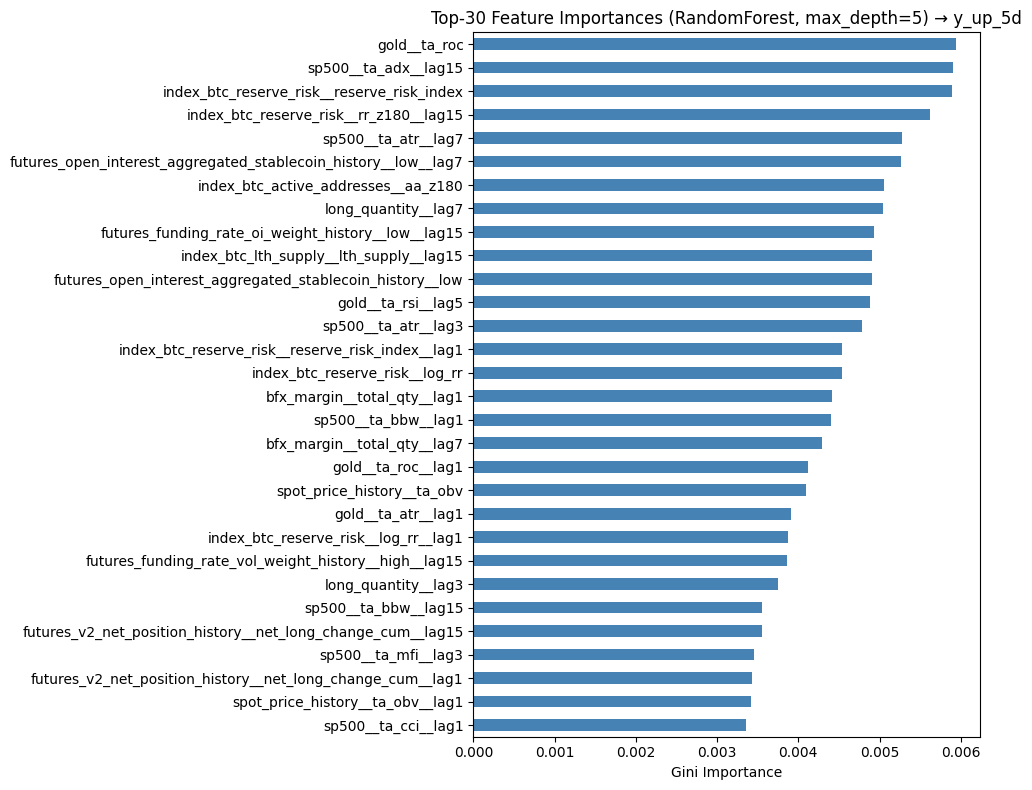


Top-30 features by Gini importance:


gold__ta_roc                                                      0.005940
sp500__ta_adx__lag15                                              0.005903
index_btc_reserve_risk__reserve_risk_index                        0.005887
index_btc_reserve_risk__rr_z180__lag15                            0.005626
sp500__ta_atr__lag7                                               0.005278
futures_open_interest_aggregated_stablecoin_history__low__lag7    0.005263
index_btc_active_addresses__aa_z180                               0.005053
long_quantity__lag7                                               0.005037
futures_funding_rate_oi_weight_history__low__lag15                0.004931
index_btc_lth_supply__lth_supply__lag15                           0.004913
futures_open_interest_aggregated_stablecoin_history__low          0.004902
gold__ta_rsi__lag5                                                0.004879
sp500__ta_atr__lag3                                               0.004786
index_btc_reserve_risk__r

In [177]:
# =============================================================================
# 8.2 Feature Importances (Gini, top-30)
# =============================================================================
importances = pd.Series(rf_model.feature_importances_, index=feature_cols_rf)
top30_imp = importances.sort_values(ascending=False).head(30)

fig, ax = plt.subplots(figsize=(10, 8))
top30_imp.sort_values().plot.barh(ax=ax, color='steelblue')
ax.set_xlabel('Gini Importance')
ax.set_title(f'Top-30 Feature Importances (RandomForest, max_depth=5) → {TARGET_COLUMN_NAME}')
plt.tight_layout()
plt.show()

print(f"\nTop-30 features by Gini importance:")
top30_imp

In [178]:
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [179]:
!C:\Users\flays\AppData\Local\Programs\Python\Python312\python.exe -m pip install shap


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\flays\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [180]:
import sys
print(sys.executable)

C:\Users\flays\AppData\Local\Programs\Python\Python312\python.exe


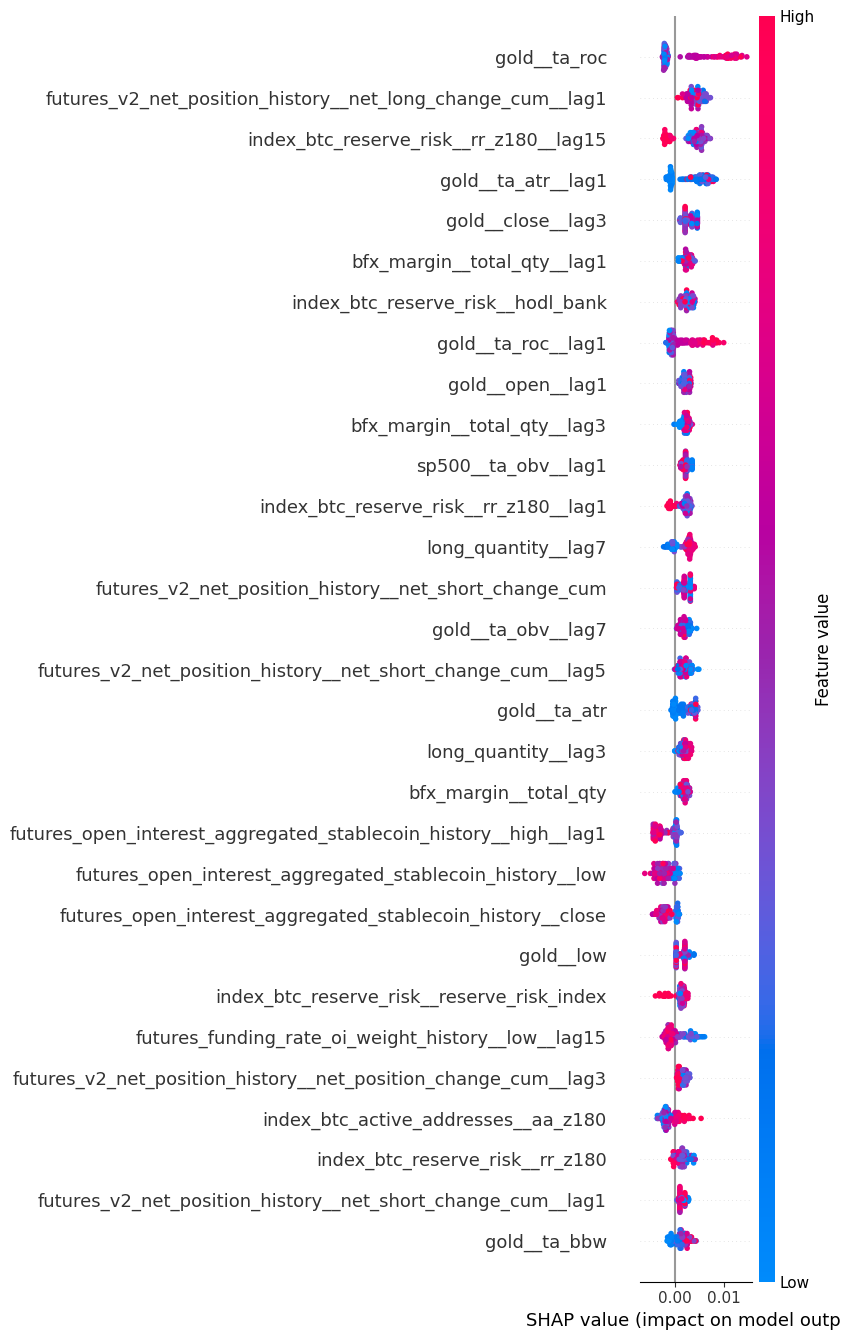

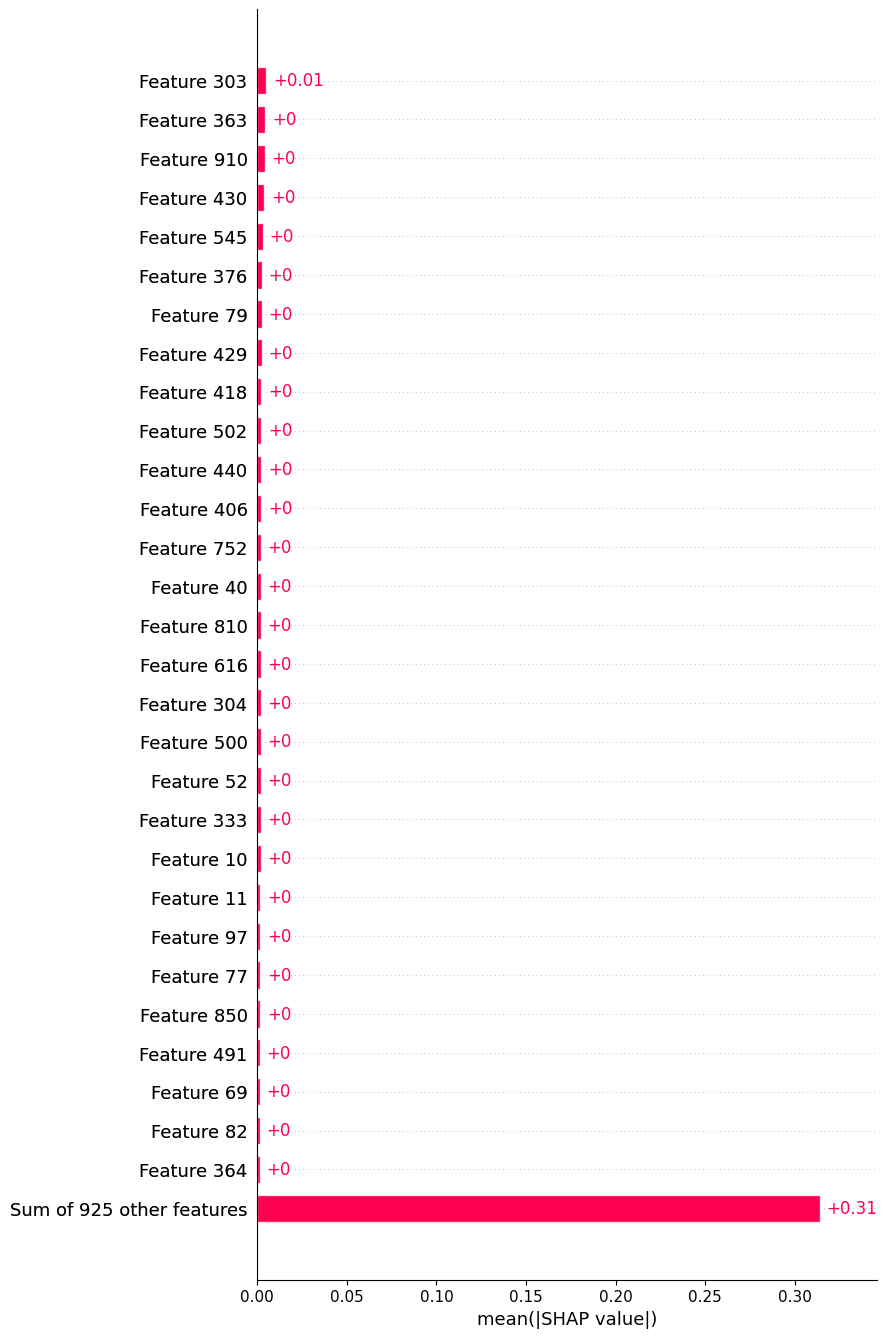

In [181]:
# =============================================================================
# 8.3 SHAP Analysis (TreeExplainer)
# =============================================================================
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

# Beeswarm plot — направление влияния каждой фичи
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=feature_cols_rf, max_display=30, show=True)

# Bar plot — средние |SHAP| значения
shap.plots.bar(shap_values[:, :, 1], max_display=30, show=True)

In [182]:
# =============================================================================
# 8.4 Сводная таблица: Gini Importance vs SHAP
# =============================================================================
mean_shap = pd.Series(
    np.abs(shap_values[:, :, 1].values).mean(axis=0),
    index=feature_cols_rf,
    name='mean_abs_shap'
)

summary = pd.DataFrame({
    'gini_importance': importances,
    'mean_abs_shap': mean_shap
}).sort_values('mean_abs_shap', ascending=False)

summary['gini_rank'] = importances.rank(ascending=False).astype(int)
summary['shap_rank'] = mean_shap.rank(ascending=False).astype(int)

print(f"Top-30 features by SHAP importance (сравнение с Gini):\n")
summary.head(30)

Top-30 features by SHAP importance (сравнение с Gini):



,gini_importance,mean_abs_shap,gini_rank,shap_rank
gold__ta_roc,0.005940,0.005032,1,1
futures_v2_net_position_history__net_long_change_cum__lag1,0.003429,0.004449,28,2
index_btc_reserve_risk__rr_z180__lag15,0.005626,0.004149,4,3
gold__ta_atr__lag1,0.003907,0.004016,21,4
gold__close__lag3,0.001084,0.003041,329,5
bfx_margin__total_qty__lag1,0.004420,0.002605,16,6
index_btc_reserve_risk__hodl_bank,0.001939,0.002518,111,7
gold__ta_roc__lag1,0.004115,0.002417,19,8
gold__open__lag1,0.001932,0.002264,114,9
bfx_margin__total_qty__lag3,0.002612,0.002244,58,10
